# Solving adjoint equations using `firedrake-adjoint`

This notebook demonstrates how to use `firedrake-adjoint` to solve an adjoint equation and extract the solution thereof.

Suppose we have a PDE in 'residual form'

$$F(u)=0,\quad u\in V,$$

for some function space $V$.
Given an objective functional $J:V\rightarrow\mathbb R$, the adjoint equation is given by

$$\frac{\partial F}{\partial u}^T\lambda=\frac{\partial J}{\partial u}^T,\quad\lambda\in V.$$

We seek to compute the adjoint solution, $\lambda$.

Suppose the PDE involves a parameter $\nu$ which is defined as a Firedrake `Constant` or `Function` (rather than a float).
Then `firedrake-adjoint` enables us to compute the gradient $\mathrm dJ/\mathrm d\nu$.
Whilst we might not actually need this for our application, performing the computation endows the `SolveVarFormBlock`s with adjoint solutions.
Why is that?

Taking the transpose of the adjoint equation gives

$$\frac{\partial J}{\partial u}=\lambda^T\frac{\partial F}{\partial u}.$$

Now, expanding the gradient $\mathrm dJ/\mathrm d\nu$ using the chain rule gives

$$
\frac{\mathrm dJ}{\mathrm d\nu}
=\frac{\partial J}{\partial u}\frac{\mathrm du}{\mathrm d\nu}+\frac{\partial J}{\partial\nu}
=\lambda^T\frac{\partial F}{\partial u}\frac{\mathrm du}{\mathrm d\nu}+\frac{\partial J}{\partial\nu}
=\lambda^T\frac{\partial F}{\partial\nu}+\frac{\partial J}{\partial\nu}.
$$

In order to compute the gradient $\mathrm dJ/\mathrm d\nu$, it is therefore sufficient to evaluate:
1. the adjoint solution, $\lambda$;
2. the _partial_ derivative of the PDE residual w.r.t. the parameter $\nu$;
3. the _partial_ derivative of the objective functional w.r.t. $\nu$.

In order to compute the gradient, `firedrake-adjoint` does all three of these things.

## The forward problem

Import Firedrake with adjoint mode activated.

In [1]:
# Code in this cell makes plots appear an appropriate size and resolution in the browser window
%matplotlib widget
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (11, 6)

In [2]:
from firedrake import *
from firedrake.adjoint import *
continue_annotation()

True

We employ the same finite element discretisation of Burgers equation in $\mathbb P2$ space as in the [Firedrake demo](https://firedrakeproject.org/demos/burgers.py.html). Here $\nu$ is the viscosity.

In [3]:
# Define a simple mesh
n = 32
mesh = UnitSquareMesh(n, n)

# Define P2 function space and corresponding test function
V = VectorFunctionSpace(mesh, "Lagrange", 2)
v = TestFunction(V)

# Create Functions for the solution and time-lagged solution
u = Function(V, name="Velocity")
u_ = Function(V)

# Assign initial condition
x, y = SpatialCoordinate(mesh)
u_ = assemble(interpolate(as_vector([sin(pi*x), 0]), V))
u.assign(u_)

# Set diffusivity constant
R = FunctionSpace(mesh, "R", 0)
nu = Function(R)
nu.assign(0.0001)

# Define nonlinear form
dt = 1.0/n
F = (inner((u - u_)/dt, v) + inner(dot(u, nabla_grad(u)), v) + nu*inner(grad(u), grad(v)))*dx

Having set up the residual,`F`, we are able to compute weak solutions of the PDE.

In [4]:
# Timestepping details
end_time = 0.5
timesteps_per_export = 4
num_timesteps = int(end_time/dt)
num_exports = num_timesteps//timesteps_per_export

# Store forward solution at exports so we can plot again later
forward_solutions = [u.copy(deepcopy=True)]

# Time integrate
i = 0
t = 0.0
while (t < end_time):
    solve(F == 0, u)
    u_.assign(u)
    t += dt
    i += 1
    if i % timesteps_per_export == 0:
        forward_solutions.append(u.copy(deepcopy=True))

Plot solution at each export timestep.

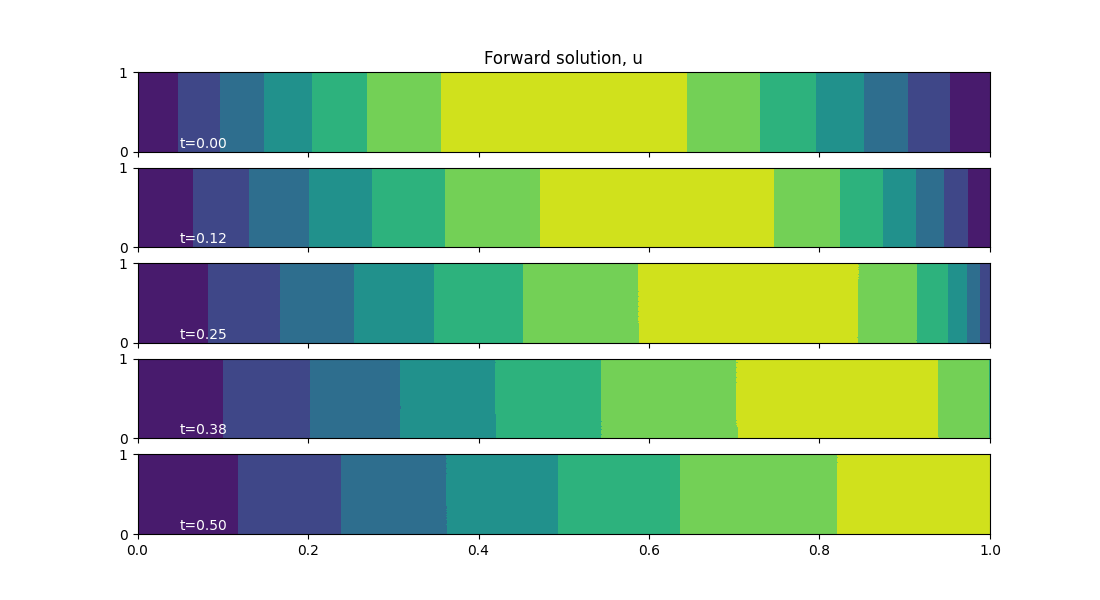

In [5]:
from firedrake.pyplot import tricontourf

fig, axs = plt.subplots(num_exports+1, sharex='col')

for i in range(len(forward_solutions)):
    tricontourf(forward_solutions[i], axes=axs[i])
    axs[i].annotate('t={:.2f}'.format(i*timesteps_per_export*dt), (0.05, 0.05), color='white');
axs[0].set_title('Forward solution, u');

## The objective functional

In order to solve the adjoint equation, we need an objective functional. For this example, consider the following integral over the 'outflow' (right hand) boundary at the final time $T$:

$$J(u)=\int_{\Gamma_2}u|_{t=T}\cdot u|_{t=T}\;\mathrm ds,
\quad\quad\Gamma_2=\{(1,y)\mid y\in(0,1)\}.$$

In [6]:
J_form = inner(u, u)*ds(2)
J = assemble(J_form)
print("Objective value: {:.4f}".format(J))

Objective value: 0.8600


Having solved the forward equation, `firedrake-adjoint` has all it needs to solve the adjoint equation.
Therefore, we can tell it to stop annotating the tape.

In [7]:
stop_annotating();

## Extracting adjoint solutions

Get the working tape and take a look at its blocks. These correspond to the (high level) operations we've performed during the simulation. For example, value assignment, FEM solves and functional assembly.

In [8]:
tape = get_working_tape()
for i, block in enumerate(tape._blocks):
    print("Block {:2d}: {:}".format(i, type(block)))

Block  0: <class 'firedrake.adjoint_utils.blocks.function.InterpolateBlock'>
Block  1: <class 'firedrake.adjoint_utils.blocks.function.FunctionAssignBlock'>
Block  2: <class 'firedrake.adjoint_utils.blocks.function.FunctionAssignBlock'>
Block  3: <class 'firedrake.adjoint_utils.blocks.function.FunctionAssignBlock'>
Block  4: <class 'firedrake.adjoint_utils.blocks.solving.SolveVarFormBlock'>
Block  5: <class 'firedrake.adjoint_utils.blocks.function.FunctionAssignBlock'>
Block  6: <class 'firedrake.adjoint_utils.blocks.solving.SolveVarFormBlock'>
Block  7: <class 'firedrake.adjoint_utils.blocks.function.FunctionAssignBlock'>
Block  8: <class 'firedrake.adjoint_utils.blocks.solving.SolveVarFormBlock'>
Block  9: <class 'firedrake.adjoint_utils.blocks.function.FunctionAssignBlock'>
Block 10: <class 'firedrake.adjoint_utils.blocks.solving.SolveVarFormBlock'>
Block 11: <class 'firedrake.adjoint_utils.blocks.function.FunctionAssignBlock'>
Block 12: <class 'firedrake.adjoint_utils.blocks.functi

The time integration routine is apparent, with the repeated solves (`SolveVarFormBlock`) and assignments (`FunctionAssignBlock`). Having time integrated the forward equation, we end by assembling the objective functional (`AssembleBlock`).

As discussed above, we get `firedrake-adjoint` to compute the gradient $\mathrm dJ/\mathrm d\nu$ in order to endow the solve blocks with adjoint solutions.

In [9]:
g = compute_gradient(J, Control(nu))
print("Gradient of J w.r.t. diffusivity = {:.4f}".format(*g.dat.data_ro))

Gradient of J w.r.t. diffusivity = -9.8526


### Exercise: Convince yourself that the negative gradient makes sense

- Hint 1: What is it that the objective functional quantifies?
- Hint 2: How does diffusion affect this quantity?

We are only interested in the blocks corresponding to nonlinear solves.
These may be extracted using Firedrake's helper function `get_solve_blocks`.

In [10]:
from firedrake.adjoint import get_solve_blocks

solve_blocks = get_solve_blocks()
assert len(solve_blocks) == num_timesteps

For each solve block, `block`, the adjoint solution is stored as the attribute `block.adj_sol`.

In [11]:
for block in solve_blocks:
    assert block.adj_sol is not None

By accessing these, we are now able to plot the adjoint solution.
Remember that information propagates _backwards_ in time for the adjoint, so we should view the plots in ascending order.

Since the objective functional is defined at the end time, its derivative provides an 'initial condition' for the adjoint.

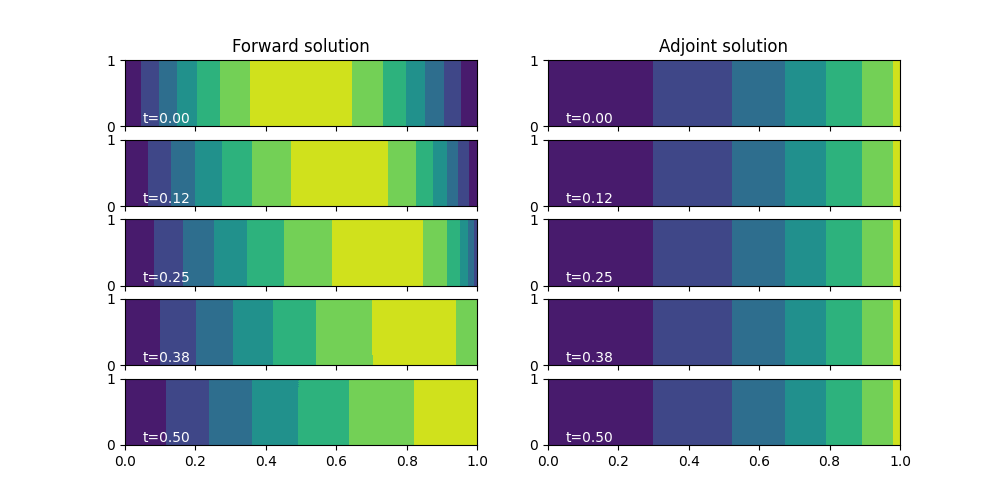

In [12]:
# 'Initial condition' for both adjoint
dJdu = assemble(derivative(J_form, u))

# Plot adjoint solutions at matching timesteps to forward
fig, axs = plt.subplots(num_exports+1, 2, sharex='col', figsize=(10, 5))
for i in range(num_exports+1):
    t = i*timesteps_per_export*dt
    tricontourf(forward_solutions[i], axes=axs[i, 0])
    adjoint_solution = dJdu if i == num_exports else solve_blocks[timesteps_per_export*i].adj_sol
    # Get the Riesz representer
    adjoint_solution = dJdu.riesz_representation(riesz_map="H1")
    tricontourf(adjoint_solution, axes=axs[i, 1])
    axs[i, 0].annotate('t={:.2f}'.format(t), (0.05, 0.05), color='white');
    axs[i, 1].annotate('t={:.2f}'.format(t), (0.05, 0.05), color='white');

# Plot formatting
axs[0, 0].set_title('Forward solution');
axs[0, 1].set_title('Adjoint solution');